In [1]:
#@title **Make sure the correct version of TF. It is needed for class_weights properly working.**
!pip install tensorflow==2.15.1
import tensorflow as tf
print("Should print 2.15.1:", tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard
    Found existing installation

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

!pip install -q condacolab
import condacolab

condacolab.install()

import condacolab

condacolab.check()
!conda install -c conda-forge openbabel

condacolab.check()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
✨🍰✨ Everything looks OK!
✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - openbabel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.1.31  |       hbcca054_0         154 KB  conda-forge
    cairo-1.18.2               |       h3394656_1         956 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge
    font-ttf-inconsolata-3.000 |       h77eed37_0          94 KB  conda-forge
    font-ttf-source-code-p

In [2]:
import tensorflow as tf
print("Should print 2.15.1:", tf.__version__)

Should print 2.15.1: 2.15.1


In [3]:
#@title **Install dependencies, including tfbio.**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
import sys
!pip install rdkit
!pip -q install py3Dmol
!pip install git+https://github.com/pablo-arantes/biopandas
!mamba install openmmforcefields -c conda-forge -y
!pip install prolif
!mamba install -c conda-forge openbabel -y
!mamba install -c conda-forge ambertools -y
!mamba install -c conda-forge parmed -y
!pip install --upgrade MDAnalysis
!pip install biopython

import parmed as pmd
from biopandas.pdb import PandasPdb
import os
import urllib.request
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdForceFieldHelpers
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image

import os
import subprocess
import pickle
import numpy as np

from openbabel import pybel
from math import ceil, sin, cos, sqrt, pi
from itertools import combinations


class Featurizer():
    """Calcaulates atomic features for molecules. Features can encode atom type,
    native pybel properties or any property defined with SMARTS patterns

    Attributes
    ----------
    FEATURE_NAMES: list of strings
        Labels for features (in the same order as features)
    NUM_ATOM_CLASSES: int
        Number of atom codes
    ATOM_CODES: dict
        Dictionary mapping atomic numbers to codes
    NAMED_PROPS: list of string
        Names of atomic properties to retrieve from pybel.Atom object
    CALLABLES: list of callables
        Callables used to calculcate custom atomic properties
    SMARTS: list of SMARTS strings
        SMARTS patterns defining additional atomic properties
    """

    def __init__(self, atom_codes=None, atom_labels=None,
                 named_properties=None, save_molecule_codes=True,
                 custom_properties=None, smarts_properties=None,
                 smarts_labels=None):

        """Creates Featurizer with specified types of features. Elements of a
        feature vector will be in a following order: atom type encoding
        (defined by atom_codes), Pybel atomic properties (defined by
        named_properties), molecule code (if present), custom atomic properties
        (defined `custom_properties`), and additional properties defined with
        SMARTS (defined with `smarts_properties`).

        Parameters
        ----------
        atom_codes: dict, optional
            Dictionary mapping atomic numbers to codes. It will be used for
            one-hot encoging therefore if n different types are used, codes
            shpuld be from 0 to n-1. Multiple atoms can have the same code,
            e.g. you can use {6: 0, 7: 1, 8: 1} to encode carbons with [1, 0]
            and nitrogens and oxygens with [0, 1] vectors. If not provided,
            default encoding is used.
        atom_labels: list of strings, optional
            Labels for atoms codes. It should have the same length as the
            number of used codes, e.g. for `atom_codes={6: 0, 7: 1, 8: 1}` you
            should provide something like ['C', 'O or N']. If not specified
            labels 'atom0', 'atom1' etc are used. If `atom_codes` is not
            specified this argument is ignored.
        named_properties: list of strings, optional
            Names of atomic properties to retrieve from pybel.Atom object. If
            not specified ['hyb', 'heavyvalence', 'heterovalence',
            'partialcharge'] is used.
        save_molecule_codes: bool, optional (default True)
            If set to True, there will be an additional feature to save
            molecule code. It is usefeul when saving molecular complex in a
            single array.
        custom_properties: list of callables, optional
            Custom functions to calculate atomic properties. Each element of
            this list should be a callable that takes pybel.Atom object and
            returns a float. If callable has `__name__` property it is used as
            feature label. Otherwise labels 'func<i>' etc are used, where i is
            the index in `custom_properties` list.
        smarts_properties: list of strings, optional
            Additional atomic properties defined with SMARTS patterns. These
            patterns should match a single atom. If not specified, deafult
            patterns are used.
        smarts_labels: list of strings, optional
            Labels for properties defined with SMARTS. Should have the same
            length as `smarts_properties`. If not specified labels 'smarts0',
            'smarts1' etc are used. If `smarts_properties` is not specified
            this argument is ignored.
        """

        # Remember namse of all features in the correct order
        self.FEATURE_NAMES = []

        if atom_codes is not None:
            if not isinstance(atom_codes, dict):
                raise TypeError('Atom codes should be dict, got %s instead'
                                % type(atom_codes))
            codes = set(atom_codes.values())
            for i in range(len(codes)):
                if i not in codes:
                    raise ValueError('Incorrect atom code %s' % i)

            self.NUM_ATOM_CLASSES = len(codes)
            self.ATOM_CODES = atom_codes
            if atom_labels is not None:
                if len(atom_labels) != self.NUM_ATOM_CLASSES:
                    raise ValueError('Incorrect number of atom labels: '
                                     '%s instead of %s'
                                     % (len(atom_labels), self.NUM_ATOM_CLASSES))
            else:
                atom_labels = ['atom%s' % i for i in range(self.NUM_ATOM_CLASSES)]
            self.FEATURE_NAMES += atom_labels
        else:
            self.ATOM_CODES = {}

            metals = ([3, 4, 11, 12, 13] + list(range(19, 32))
                      + list(range(37, 51)) + list(range(55, 84))
                      + list(range(87, 104)))

            # List of tuples (atomic_num, class_name) with atom types to encode.
            atom_classes = [
                (5, 'B'),
                (6, 'C'),
                (7, 'N'),
                (8, 'O'),
                (15, 'P'),
                (16, 'S'),
                (34, 'Se'),
                ([9, 17, 35, 53], 'halogen'),
                (metals, 'metal')
            ]

            for code, (atom, name) in enumerate(atom_classes):
                if type(atom) is list:
                    for a in atom:
                        self.ATOM_CODES[a] = code
                else:
                    self.ATOM_CODES[atom] = code
                self.FEATURE_NAMES.append(name)

            self.NUM_ATOM_CLASSES = len(atom_classes)

        if named_properties is not None:
            if not isinstance(named_properties, (list, tuple, np.ndarray)):
                raise TypeError('named_properties must be a list')
            allowed_props = [prop for prop in dir(pybel.Atom)
                             if not prop.startswith('__')]
            for prop_id, prop in enumerate(named_properties):
                if prop not in allowed_props:
                    raise ValueError(
                        'named_properties must be in pybel.Atom attributes,'
                        ' %s was given at position %s' % (prop_id, prop)
                    )
            self.NAMED_PROPS = named_properties
        else:
            # pybel.Atom properties to save
            self.NAMED_PROPS = ['hyb', 'heavydegree', 'heterodegree',
                                'partialcharge']
        self.FEATURE_NAMES += self.NAMED_PROPS

        if not isinstance(save_molecule_codes, bool):
            raise TypeError('save_molecule_codes should be bool, got %s '
                            'instead' % type(save_molecule_codes))
        self.save_molecule_codes = save_molecule_codes
        if save_molecule_codes:
            # Remember if an atom belongs to the ligand or to the protein
            self.FEATURE_NAMES.append('molcode')

        self.CALLABLES = []
        if custom_properties is not None:
            for i, func in enumerate(custom_properties):
                if not callable(func):
                    raise TypeError('custom_properties should be list of'
                                    ' callables, got %s instead' % type(func))
                name = getattr(func, '__name__', '')
                if name == '':
                    name = 'func%s' % i
                self.CALLABLES.append(func)
                self.FEATURE_NAMES.append(name)

        if smarts_properties is None:
            # SMARTS definition for other properties
            self.SMARTS = [
                '[#6+0!$(*~[#7,#8,F]),SH0+0v2,s+0,S^3,Cl+0,Br+0,I+0]',
                '[a]',
                '[!$([#1,#6,F,Cl,Br,I,o,s,nX3,#7v5,#15v5,#16v4,#16v6,*+1,*+2,*+3])]',
                '[!$([#6,H0,-,-2,-3]),$([!H0;#7,#8,#9])]',
                '[r]'
            ]
            smarts_labels = ['hydrophobic', 'aromatic', 'acceptor', 'donor',
                             'ring']
        elif not isinstance(smarts_properties, (list, tuple, np.ndarray)):
            raise TypeError('smarts_properties must be a list')
        else:
            self.SMARTS = smarts_properties

        if smarts_labels is not None:
            if len(smarts_labels) != len(self.SMARTS):
                raise ValueError('Incorrect number of SMARTS labels: %s'
                                 ' instead of %s'
                                 % (len(smarts_labels), len(self.SMARTS)))
        else:
            smarts_labels = ['smarts%s' % i for i in range(len(self.SMARTS))]

        # Compile patterns
        self.compile_smarts()
        self.FEATURE_NAMES += smarts_labels

    def compile_smarts(self):
        self.__PATTERNS = []
        for smarts in self.SMARTS:
            self.__PATTERNS.append(pybel.Smarts(smarts))

    def encode_num(self, atomic_num):
        """Encode atom type with a binary vector. If atom type is not included in
        the `atom_classes`, its encoding is an all-zeros vector.

        Parameters
        ----------
        atomic_num: int
            Atomic number

        Returns
        -------
        encoding: np.ndarray
            Binary vector encoding atom type (one-hot or null).
        """

        if not isinstance(atomic_num, int):
            raise TypeError('Atomic number must be int, %s was given'
                            % type(atomic_num))

        encoding = np.zeros(self.NUM_ATOM_CLASSES)
        try:
            encoding[self.ATOM_CODES[atomic_num]] = 1.0
        except:
            pass
        return encoding

    def find_smarts(self, molecule):
        """Find atoms that match SMARTS patterns.

        Parameters
        ----------
        molecule: pybel.Molecule

        Returns
        -------
        features: np.ndarray
            NxM binary array, where N is the number of atoms in the `molecule`
            and M is the number of patterns. `features[i, j]` == 1.0 if i'th
            atom has j'th property
        """

        if not isinstance(molecule, pybel.Molecule):
            raise TypeError('molecule must be pybel.Molecule object, %s was given'
                            % type(molecule))

        features = np.zeros((len(molecule.atoms), len(self.__PATTERNS)))

        for (pattern_id, pattern) in enumerate(self.__PATTERNS):
            atoms_with_prop = np.array(list(*zip(*pattern.findall(molecule))),
                                       dtype=int) - 1
            features[atoms_with_prop, pattern_id] = 1.0
        return features

    def get_features(self, molecule, molcode=None):
        """Get coordinates and features for all heavy atoms in the molecule.

        Parameters
        ----------
        molecule: pybel.Molecule
        molcode: float, optional
            Molecule type. You can use it to encode whether an atom belongs to
            the ligand (1.0) or to the protein (-1.0) etc.

        Returns
        -------
        coords: np.ndarray, shape = (N, 3)
            Coordinates of all heavy atoms in the `molecule`.
        features: np.ndarray, shape = (N, F)
            Features of all heavy atoms in the `molecule`: atom type
            (one-hot encoding), pybel.Atom attributes, type of a molecule
            (e.g protein/ligand distinction), and other properties defined with
            SMARTS patterns
        """

        if not isinstance(molecule, pybel.Molecule):
            raise TypeError('molecule must be pybel.Molecule object,'
                            ' %s was given' % type(molecule))
        if molcode is None:
            if self.save_molecule_codes is True:
                raise ValueError('save_molecule_codes is set to True,'
                                 ' you must specify code for the molecule')
        elif not isinstance(molcode, (float, int)):
            raise TypeError('motlype must be float, %s was given'
                            % type(molcode))

        coords = []
        features = []
        heavy_atoms = []

        for i, atom in enumerate(molecule):
            # ignore hydrogens and dummy atoms (they have atomicnum set to 0)
            if atom.atomicnum > 1:
                heavy_atoms.append(i)
                coords.append(atom.coords)

                features.append(np.concatenate((
                    self.encode_num(atom.atomicnum),
                    [atom.__getattribute__(prop) for prop in self.NAMED_PROPS],
                    [func(atom) for func in self.CALLABLES],
                )))

        coords = np.array(coords, dtype=np.float32)
        features = np.array(features, dtype=np.float32)
        if self.save_molecule_codes:
            features = np.hstack((features,
                                  molcode * np.ones((len(features), 1))))
        features = np.hstack([features,
                              self.find_smarts(molecule)[heavy_atoms]])

        if np.isnan(features).any():
            raise RuntimeError('Got NaN when calculating features')

        return coords, features

    def to_pickle(self, fname='featurizer.pkl'):
        """Save featurizer in a given file. Featurizer can be restored with
        `from_pickle` method.

        Parameters
        ----------
        fname: str, optional
           Path to file in which featurizer will be saved
        """

        # patterns can't be pickled, we need to temporarily remove them
        patterns = self.__PATTERNS[:]
        del self.__PATTERNS
        try:
            with open(fname, 'wb') as f:
                pickle.dump(self, f)
        finally:
            self.__PATTERNS = patterns[:]

    @staticmethod
    def from_pickle(fname):
        """Load pickled featurizer from a given file

        Parameters
        ----------
        fname: str, optional
           Path to file with saved featurizer

        Returns
        -------
        featurizer: Featurizer object
           Loaded featurizer
        """
        with open(fname, 'rb') as f:
            featurizer = pickle.load(f)
        featurizer.compile_smarts()
        return featurizer

def soft_dice_coefficient(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)

    volume_true = tf.reduce_sum(tf.square(y_true_flat))
    volume_pred = tf.reduce_sum(tf.square(y_pred_flat))

    dice = (2. * intersection + tf.keras.backend.epsilon()) / \
           (volume_true + volume_pred + tf.keras.backend.epsilon())
    return dice

def soft_dice_loss(y_true, y_pred):
    return 1 - soft_dice_coefficient(y_true, y_pred)


In [4]:
import os
import numpy as np

# Directory where preprocessed data is saved
save_dir = '.../Combined_UNCUT_preprocessing'

# Load inputs and outputs
inputs_0 = np.load(os.path.join(save_dir, 'scpdb_inputs_0.npy'))
outputs_0 = np.load(os.path.join(save_dir, 'scpdb_outputs_0.npy'))

inputs_1 = np.load(os.path.join(save_dir, 'scpdb_inputs_1.npy'))
outputs_1 = np.load(os.path.join(save_dir, 'scpdb_outputs_1.npy'))

inputs_2 = np.load(os.path.join(save_dir, 'scpdb_inputs_2.npy'))
outputs_2 = np.load(os.path.join(save_dir, 'scpdb_outputs_2.npy'))

inputs_3 = np.load(os.path.join(save_dir, 'scpdb_inputs_3.npy'))
outputs_3 = np.load(os.path.join(save_dir, 'scpdb_outputs_3.npy'))

inputs_4 = np.load(os.path.join(save_dir, 'scpdb_inputs_4.npy'))
outputs_4 = np.load(os.path.join(save_dir, 'scpdb_outputs_4.npy'))

inputs = np.concatenate((inputs_0, inputs_1, inputs_2, inputs_3, inputs_4), axis=0)
outputs = np.concatenate((outputs_0, outputs_1, outputs_2, outputs_3, outputs_4), axis=0)

print(f"Input data shape: {inputs.shape}")
print(f"Output data shape: {outputs.shape}")

Input data shape: (5020, 36, 36, 36, 18)
Output data shape: (5020, 36, 36, 36, 1)


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

outputs_flat = outputs.flatten()

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(outputs_flat),
                                     y=outputs_flat)

# Convert to a dictionary
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights_dict)

Class weights: {0: 0.1671444675365879, 1: 114.95844646927513, 2: 156.0054192527346, 3: 544.9148472834887, 4: 4819.2, 5: 5576502.857142857}


In [6]:
class_weights

array([1.67144468e-01, 1.14958446e+02, 1.56005419e+02, 5.44914847e+02,
       4.81920000e+03, 5.57650286e+06])

In [ ]:
class_weights_dict = {0: 0.1671444675365879,
 1: 114.95844646927513,
 2: 156.0054192527346,
 3: 544.9148472834887,
 4: 4819.2,
 5: 5576502.857142857}

{0: 0.1671444675365879,
 1: 114.95844646927513,
 2: 156.0054192527346,
 3: 544.9148472834887,
 4: 4819.2,
 5: 5576502.857142857}

In [6]:
#@title **RAPID_Net model**
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Activation, add, SpatialDropout3D, GlobalAveragePooling3D, Reshape, Dense, multiply, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

def identity_block(input_tensor, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = -1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv3D(filters1, (1, 1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters2, (3, 3, 3), padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters3, (1, 1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, filters, stage, block, strides=(2, 2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = -1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv3D(filters1, (1, 1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters2, (3, 3, 3), padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters3, (1, 1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv3D(filters3, (1, 1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]

    se = GlobalAveragePooling3D()(input_tensor)
    se = Reshape((1, 1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = multiply([input_tensor, se])
    return x

def RAPID_Net(input_shape=(36, 36, 36, 18), filters=18, dropout_rate=0.5, l2_lambda=1e-3):
    params = {'kernel_size': 3, 'activation': 'relu', 'padding': 'same', 'kernel_regularizer': l2(l2_lambda)}

    inputs = Input(shape=input_shape, name='input')

    x = conv_block(inputs, [filters, filters, filters], stage=2, block='a', strides=(1, 1, 1))
    x1 = identity_block(x, [filters, filters, filters], stage=2, block='b')

    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(x1)

    x = conv_block(pool1, [filters*2, filters*2, filters*2], stage=4, block='a', strides=(1, 1, 1))
    x2 = identity_block(x, [filters*2, filters*2, filters*2], stage=4, block='b')

    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(x2)

    x = conv_block(pool2, [filters*4, filters*4, filters*4], stage=5, block='a', strides=(1, 1, 1))
    x3 = identity_block(x, [filters*4, filters*4, filters*4], stage=5, block='b')

    pool3 = MaxPooling3D(pool_size=(3, 3, 3))(x3)

    x = conv_block(pool3, [filters*8, filters*8, filters*8], stage=6, block='a', strides=(1, 1, 1))
    x4 = identity_block(x, [filters*8, filters*8, filters*8], stage=6, block='b')

    pool4 = MaxPooling3D(pool_size=(3, 3, 3))(x4)

    x = conv_block(pool4, [filters*16, filters*16, filters*16], stage=7, block='a', strides=(1, 1, 1))
    x = identity_block(x, [filters*16, filters*16, filters*16], stage=7, block='b')

    x = se_block(x)

    up6 = concatenate([UpSampling3D(size=(3, 3, 3))(x), x4], axis=-1)
    conv6 = Conv3D(filters=filters*8, **params)(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    conv6 = Conv3D(filters=filters*8, **params)(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = concatenate([UpSampling3D(size=(3, 3, 3))(conv6), x3], axis=-1)
    conv7 = Conv3D(filters=filters*4, **params)(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    conv7 = Conv3D(filters=filters*4, **params)(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up8 = concatenate([UpSampling3D(size=(2, 2, 2))(conv7), x2], axis=-1)
    conv8 = Conv3D(filters=filters*2, **params)(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    conv8 = Conv3D(filters=filters*2, **params)(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up9 = concatenate([UpSampling3D(size=(2, 2, 2))(conv8), x1], axis=-1)
    conv9 = Conv3D(filters=filters, **params)(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    conv9 = Conv3D(filters=filters, **params)(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    outputs = Conv3D(filters=1, kernel_size=1, kernel_regularizer=l2(1e-4), activation='relu', name='pocket')(conv9)

    model = Model(inputs=inputs, outputs=outputs, name='RAPID_Net')
    return model


Epoch 1/80
1004/1004 [==============================] - 74s 43ms/step - loss: 1.0431 - soft_dice_coefficient: 0.3649
Epoch 2/80
1004/1004 [==============================] - 43s 43ms/step - loss: 0.7650 - soft_dice_coefficient: 0.5209
Epoch 3/80
1004/1004 [==============================] - 43s 43ms/step - loss: 0.6757 - soft_dice_coefficient: 0.5509
Epoch 4/80
1004/1004 [==============================] - 43s 43ms/step - loss: 0.5944 - soft_dice_coefficient: 0.5685
Epoch 5/80
1004/1004 [==============================] - 43s 43ms/step - loss: 0.5620 - soft_dice_coefficient: 0.5737
Epoch 6/80
1004/1004 [==============================] - 43s 43ms/step - loss: 0.5668 - soft_dice_coefficient: 0.5619
Epoch 7/80
1004/1004 [==============================] - 43s 43ms/step - loss: 0.5119 - soft_dice_coefficient: 0.5882
Epoch 8/80
1004/1004 [==============================] - 43s 43ms/step - loss: 0.4935 - soft_dice_coefficient: 0.5866
Epoch 9/80
1004/1004 [==============================] - 43s 43ms

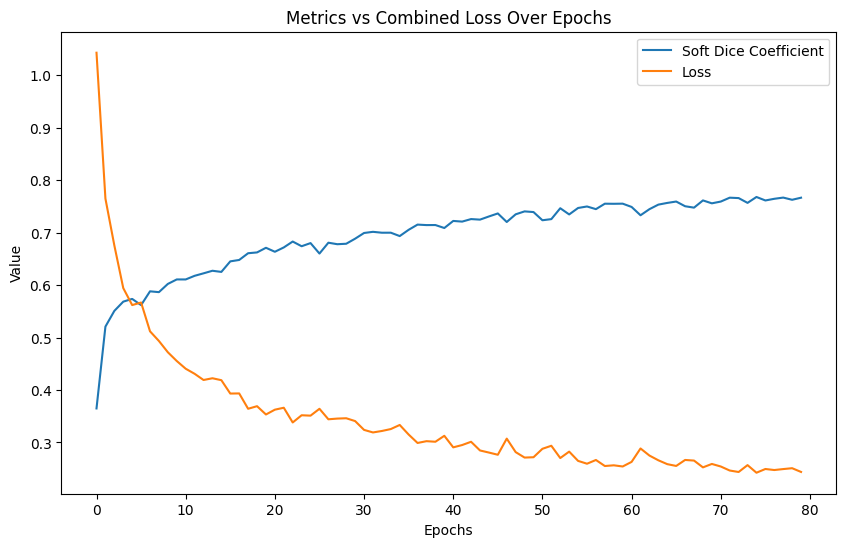

Metrics vs loss plot saved to /content/gdrive/MyDrive/PUResNet/Combined_preprocessing/metrics_vs_loss_plot.png


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

class SaveModelAtEpochs(Callback):
    def __init__(self, save_freqs, base_filepath):
        super(SaveModelAtEpochs, self).__init__()
        self.save_freqs = save_freqs
        self.base_filepath = base_filepath

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.save_freqs:
            filepath = self.base_filepath.format(epoch=epoch + 1)
            self.model.save(filepath)
            print(f"\nEpoch {epoch + 1}: saving model to {filepath}")

save_freqs =  list(range(30, 81))

base_filepath = '.../Runs/Soft_Dice_Relu_5020_Run_5_{epoch}.keras'

model = RAPID_Net(input_shape=(36, 36, 36, 18), filters=18)

#model.load_weights('')

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)

model.compile(optimizer=optimizer, loss=soft_dice_loss, metrics=[soft_dice_coefficient])

save_model_callback = SaveModelAtEpochs(save_freqs=save_freqs, base_filepath=base_filepath)

history = model.fit(inputs, outputs,
                    epochs=80,
                    batch_size=5,
                    class_weight=class_weights_dict,
                    callbacks=[save_model_callback])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(history.history['soft_dice_coefficient'], label='Soft Dice Coefficient')
plt.plot(history.history['loss'], label='Loss')

plt.title('Metrics vs Combined Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='upper right')

plot_filepath = '/content/gdrive/MyDrive/PUResNet/Combined_preprocessing/metrics_vs_loss_plot.png'
plt.savefig(plot_filepath)

plt.show()

print(f"Metrics vs loss plot saved to {plot_filepath}")

